In [1]:
import pandas as pd

In [2]:
# loading training and testing data
train_data = pd.read_csv('train (1).csv')
test_data = pd.read_csv('test.csv')

In [3]:
# initial sanity check  
train_data.columns

# train_data.info()
# train_data.isnull().sum()

# sanity check results => saleprice is target column, 81 columns in train and one less in test, missing one is target column ofc.

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

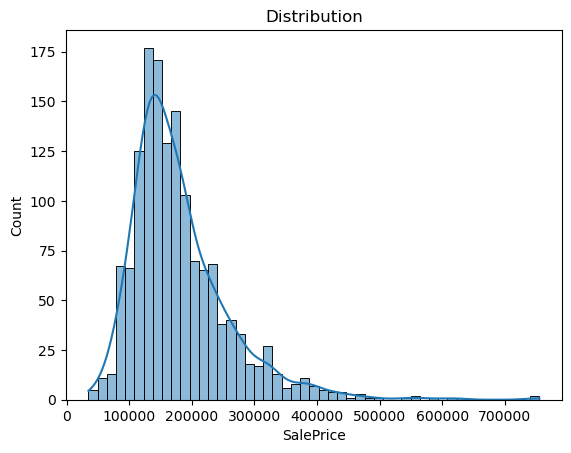

In [4]:
# visulaization
import matplotlib.pyplot as plt 
import seaborn as sns 

# basic target analysis first 
# print(train_data['SalePrice'].describe())

# plotting distribution
sns.histplot(train_data['SalePrice'], kde=True)
plt.title('Distribution')
plt.show()

# info gathered => distribution is right skewed therefore log transform might help later

### step 2 EDA

In [5]:
# checking missing values
missing_values = train_data.isnull().sum()
missing_values = missing_values[missing_values>0].sort_values(ascending=False)
missing_values

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

In [6]:
# feature type breakdown
numerical_features = train_data.select_dtypes(include = ['int64', 'float64']).columns
categorical_features = train_data.select_dtypes(include = ['object']).columns

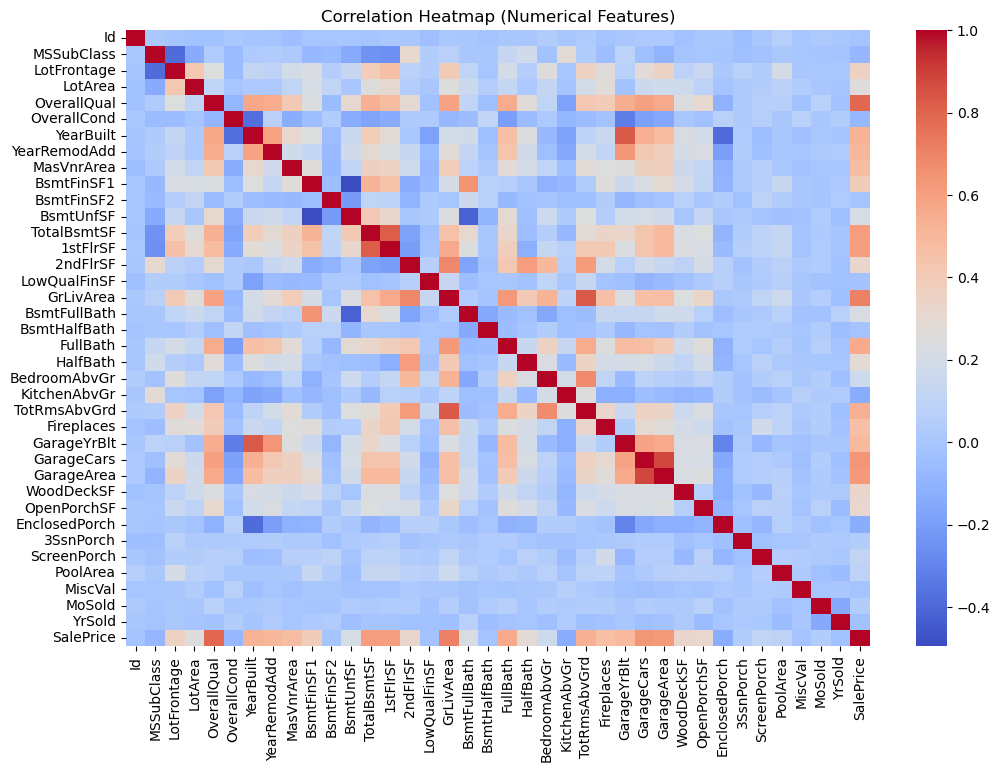

In [7]:
# finding correlation with targets
correlation = train_data[numerical_features].corr()
correlation_target = correlation['SalePrice'].sort_values(ascending=False)
correlation_target

# visulaize 
plt.figure(figsize=(12,8))
sns.heatmap(train_data[numerical_features].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

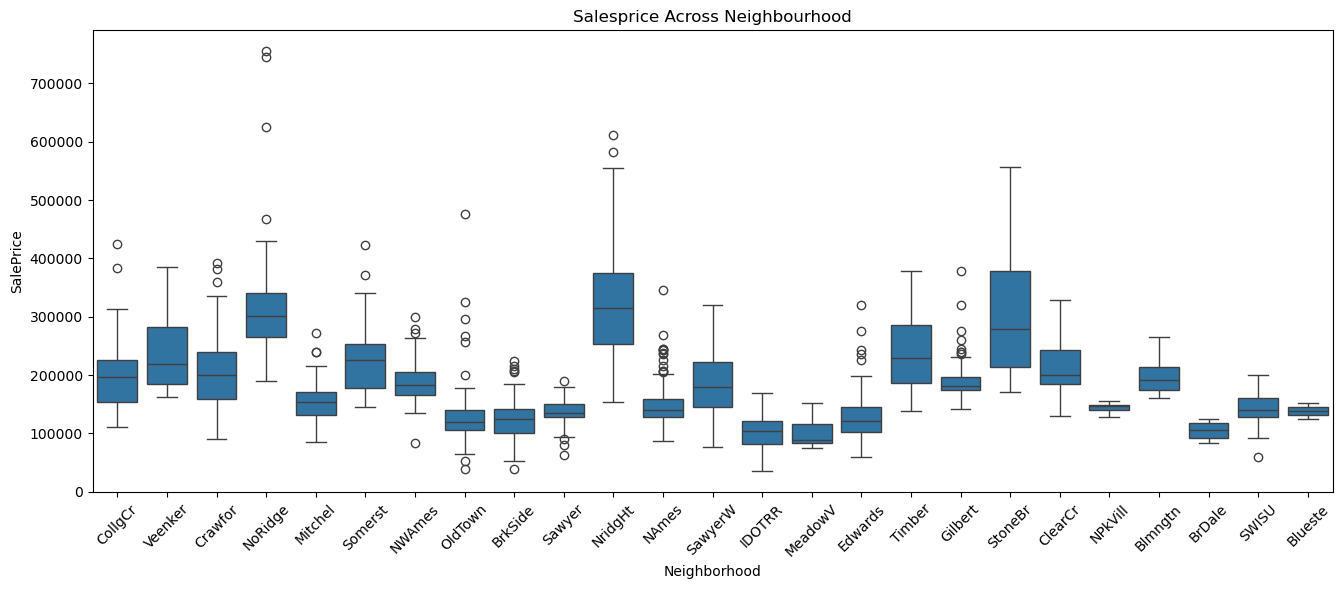

In [8]:
# categorical features vs target
plt.figure(figsize=(16, 6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=train_data)
plt.xticks(rotation=45)
plt.title("Salesprice Across Neighbourhood")
plt.show()

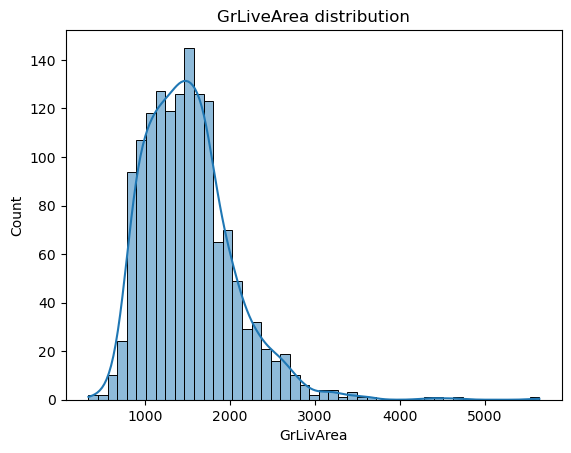

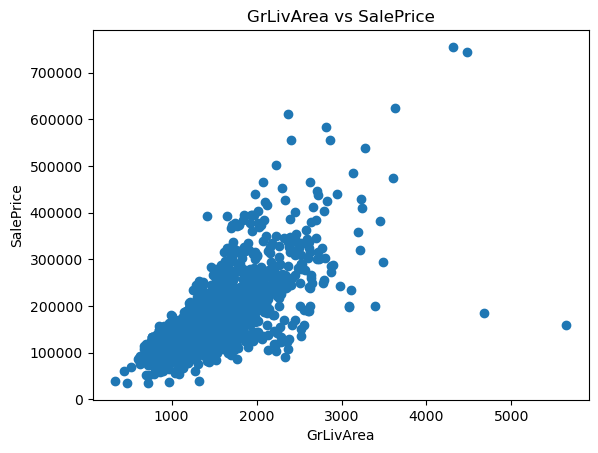

In [11]:
# Numerical feature distribution
# Example 
sns.histplot(train_data['GrLivArea'], kde=True)
plt.title("GrLiveArea distribution")
plt.show()

# scattering with salesprice 
plt.scatter(train_data['GrLivArea'], train_data['SalePrice'])
plt.title('GrLivArea vs SalePrice')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [14]:
# Detecting outliers
train_data.loc[train_data['GrLivArea']>4500][['GrLivArea', 'SalePrice']]

,GrLivArea,SalePrice
523,4676,184750
1298,5642,160000


In [15]:
# log transform for highly skewed data
from scipy.stats import skew
skewness = train_data[numerical_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness.head()

MiscVal         24.451640
PoolArea        14.813135
LotArea         12.195142
3SsnPorch       10.293752
LowQualFinSF     9.002080
dtype: float64

### step 3 data cleaning and preprocessig

In [16]:
# Handling missing values
# filling categorical columns with mode
categorical_cols = train_data.select_dtypes(include=['object']).columns

for col in categorical_cols:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])

# filling numerical features with median
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns

for num in numerical_cols:
    train_data[num] = train_data[num].fillna(train_data[num].median())

In [21]:
# outlier removal
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4500) & (train_data['SalePrice']<300000)].index)

In [23]:
# skewed numerical features
import numpy as np
skewed_feats = train_data[numerical_cols].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats>0.75].index                                               

# apply lop1p log(1+x)
train_data[skewed_feats] = np.log1p(train_data[skewed_feats])
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])

In [24]:
# encoding categorical columns
train_data = pd.get_dummies(train_data)
train_data.shape

(1458, 288)

In [26]:
# final target and features split
x = train_data.drop('SalePrice', axis=1)
y = train_data['SalePrice']

In [27]:
# # scaling 
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(x)

### step 4 Feature Engineering 

In [29]:
# creating new features
# total square footage
train_data['TotalSF'] = train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF']

# bathroom contribution to price
train_data['TotalBath'] = (train_data['FullBath'] + train_data['HalfBath'] * 0.5 +
                           train_data['BsmtFullBath'] + train_data['BsmtHalfBath'] * 0.5)

# newer homes might sell higher (age of house)
train_data['AgeOfHouse'] = train_data['YrSold'] - train_data['YearBuilt']

# Age Since Remodel (better than absolute year)
train_data['AgeSinceRemodel'] = train_data['YrSold'] - train_data['YearRemodAdd']

In [30]:
# droppying redundant features
train_data.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath',
                 'YearBuilt', 'YearRemodAdd'], axis=1, inplace=True)

In [35]:
# updating x and scaling again
x = train_data.drop('SalePrice', axis=1)
y = train_data['SalePrice']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

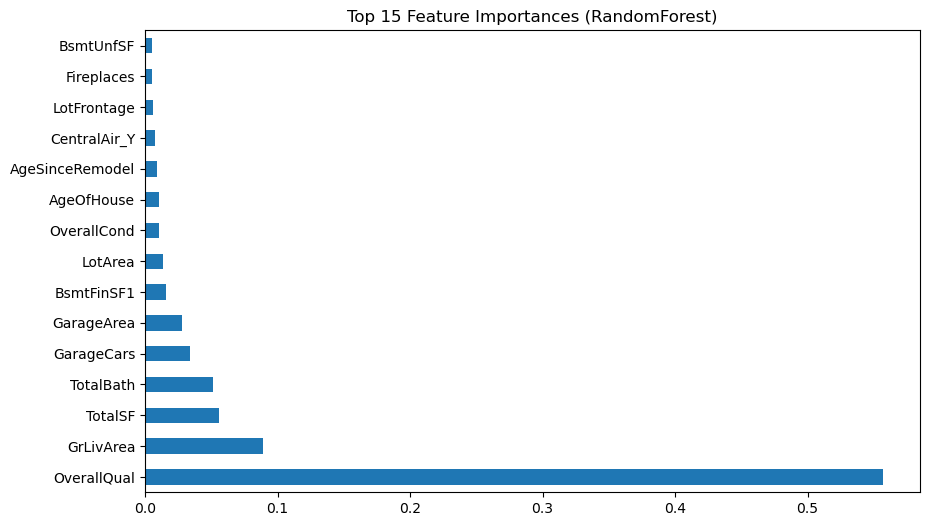

In [38]:
# checking feature importance
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd

rf = RandomForestRegressor()
rf.fit(x_scaled, y)

importance = pd.Series(rf.feature_importances_, index = x.columns)
importance.nlargest(15).plot(kind='barh', figsize=(10, 6))
plt.title('Top 15 Feature Importances (RandomForest)')
plt.show()

### step 5 visualization

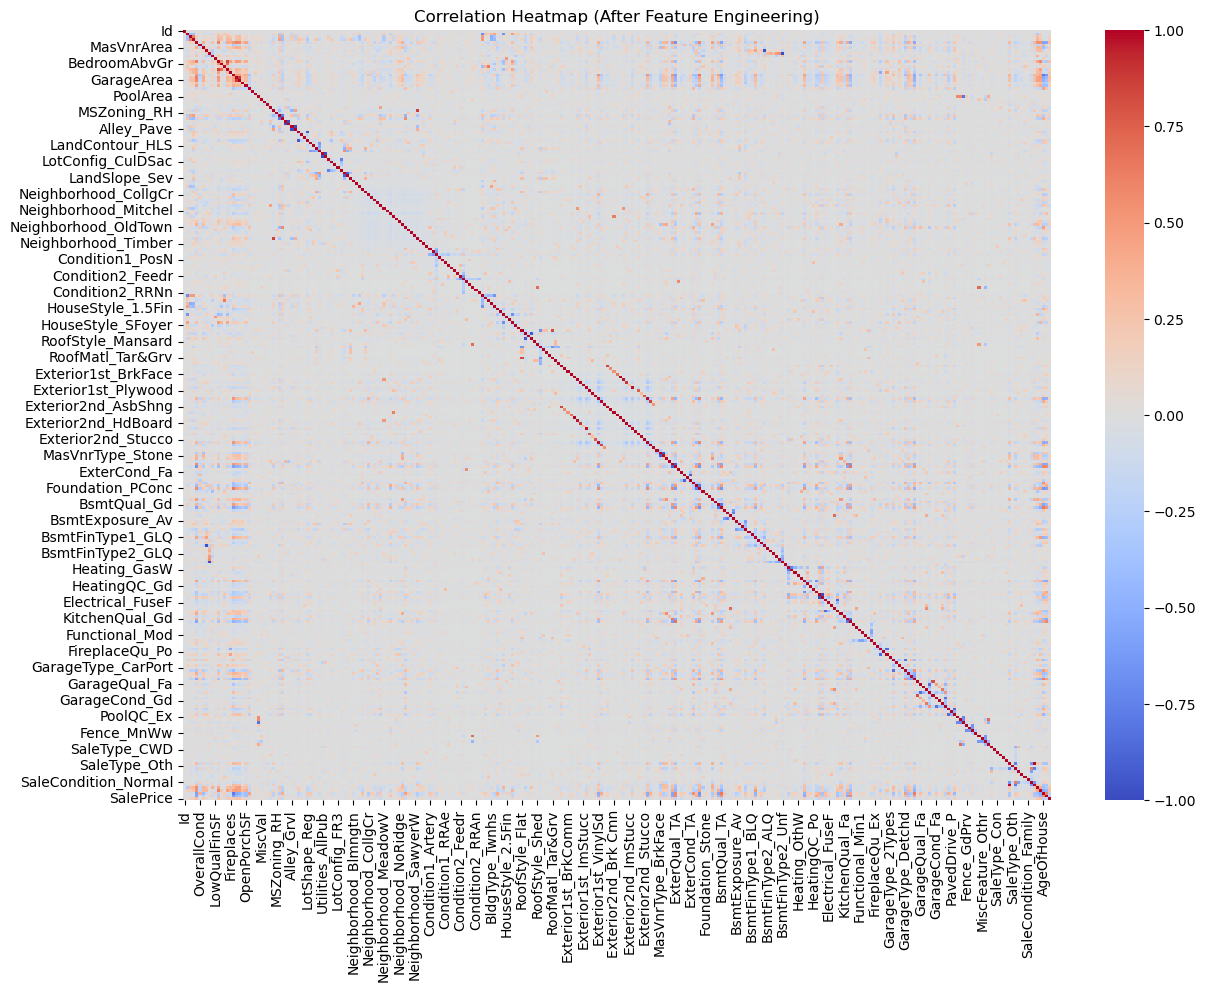

In [40]:
import seaborn as sns

# recreating the dataframe
x_df = pd.DataFrame(x_scaled, columns=x.columns)
x_df['SalePrice'] = y

# correlation matrix
corr = x_df.corr()

# plotting
plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap (After Feature Engineering)')
plt.show()

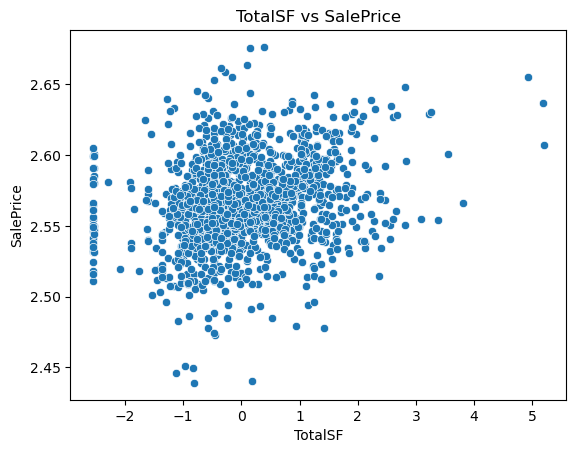

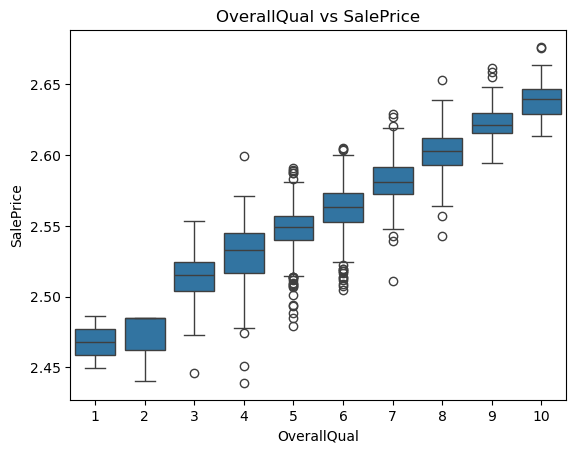

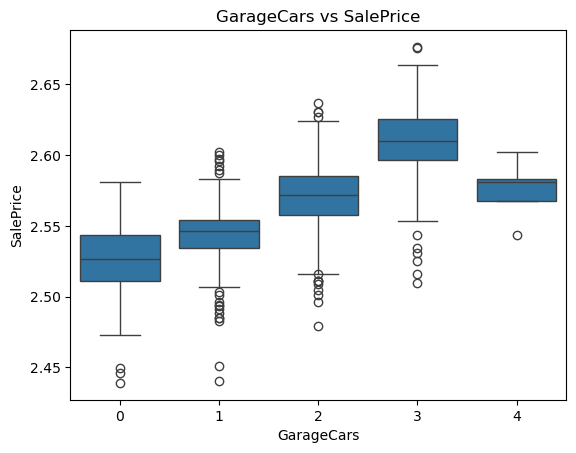

In [42]:
# Total Square Footage vs SalePrice
sns.scatterplot(x='TotalSF', y='SalePrice', data=x_df)
plt.title('TotalSF vs SalePrice')
plt.show()

# Overall Quality (Categorical-like) vs SalePrice
sns.boxplot(x=train_data['OverallQual'], y=y)
plt.title('OverallQual vs SalePrice')
plt.show()

# GarageCars (Another categorical-like) vs SalePrice
sns.boxplot(x=train_data['GarageCars'], y=y)
plt.title('GarageCars vs SalePrice')
plt.show()


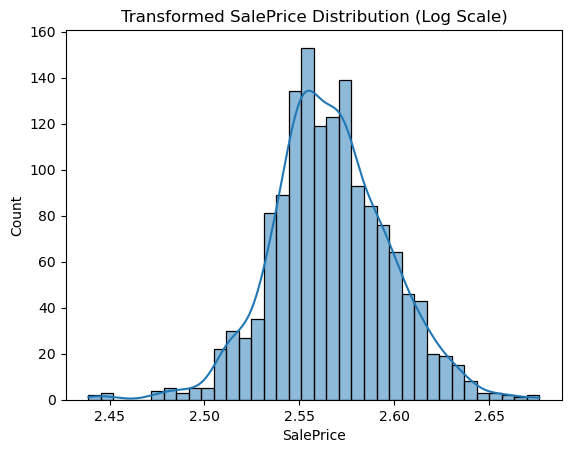

In [43]:
sns.histplot(y, kde=True)
plt.title('Transformed SalePrice Distribution (Log Scale)')
plt.show()

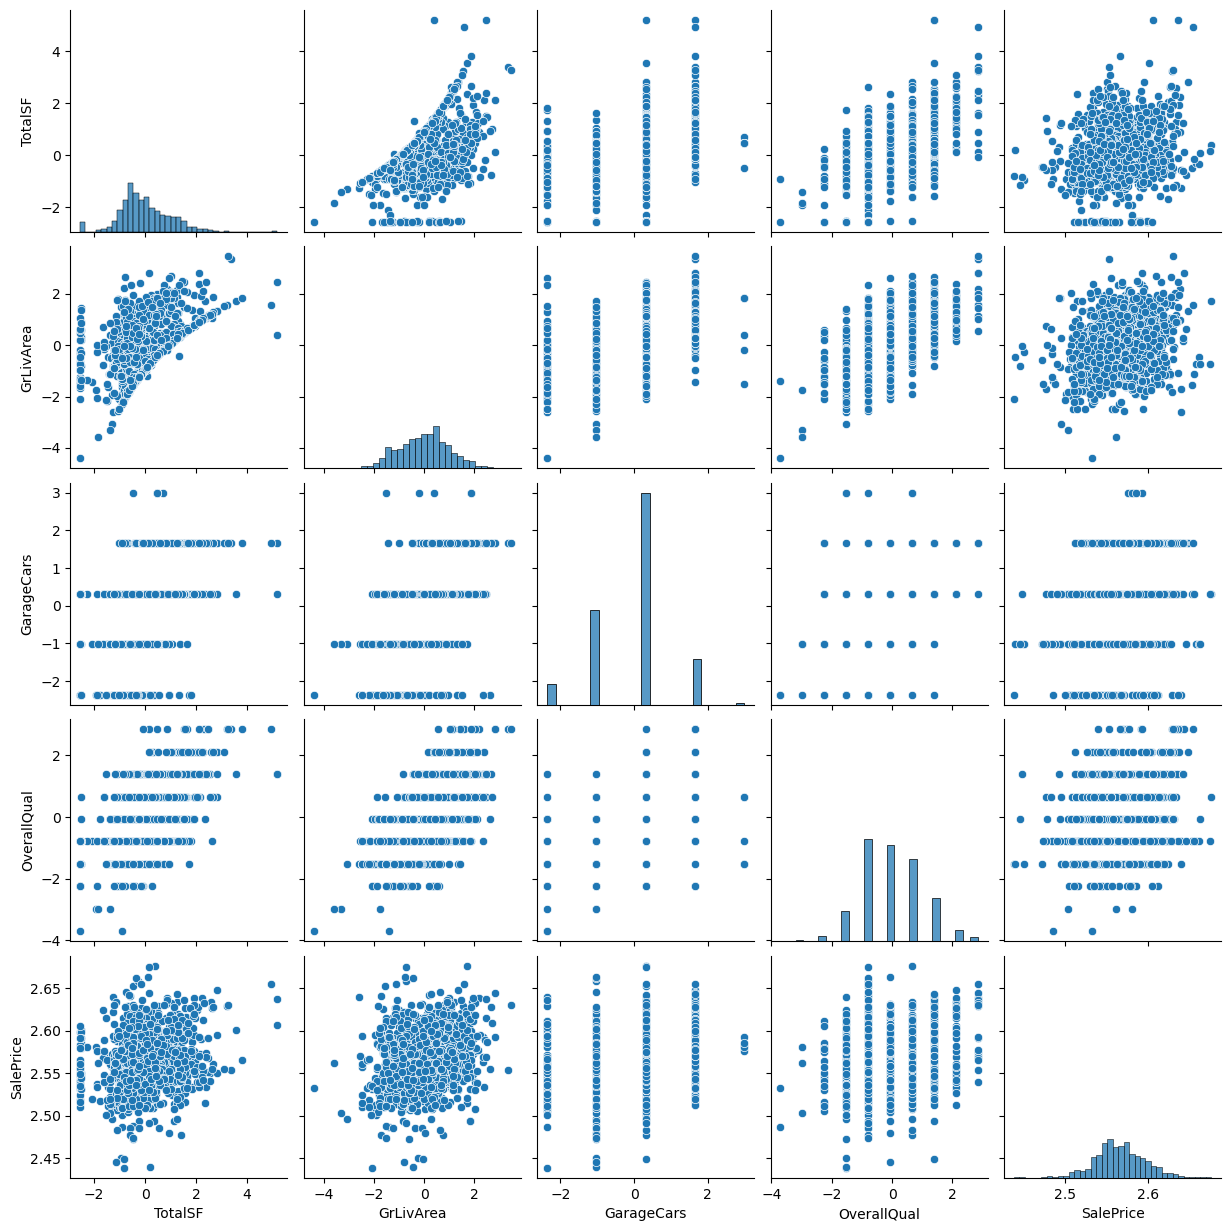

In [45]:
# strong features plots
strong_features = ['TotalSF', 'GrLivArea', 'GarageCars', 'OverallQual', 'SalePrice']
sns.pairplot(x_df[strong_features])
plt.show()

### step 6 modelling

In [46]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state=42)

In [49]:
# models using LR, RR, Lasso Regression, Random forest Xregressor, XGboost Regressor
# linear regressor first
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))

Linear Regression RMSE: 138462885212.06955
Linear Regression R2: -1.906198941466427e+25


In [50]:
# Ridge and lasso
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge(alpha=10)
ridge.fit(x_train, y_train)
y_pred_ridge = ridge.predict(x_test)

lasso = Lasso(alpha=0.001)
lasso.fit(x_train, y_train)
y_pred_lasso = lasso.predict(x_test)

print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))

Ridge RMSE: 0.00960436762811673
Lasso RMSE: 0.00968334358151475


In [52]:
# Random forest regressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest RMSE: 0.011491055403246441


In [57]:
# XGboost 
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
xgb.fit(x_train, y_train)
y_pred_xgb = xgb.predict(x_test)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

XGBoost RMSE: 0.011200419175786964


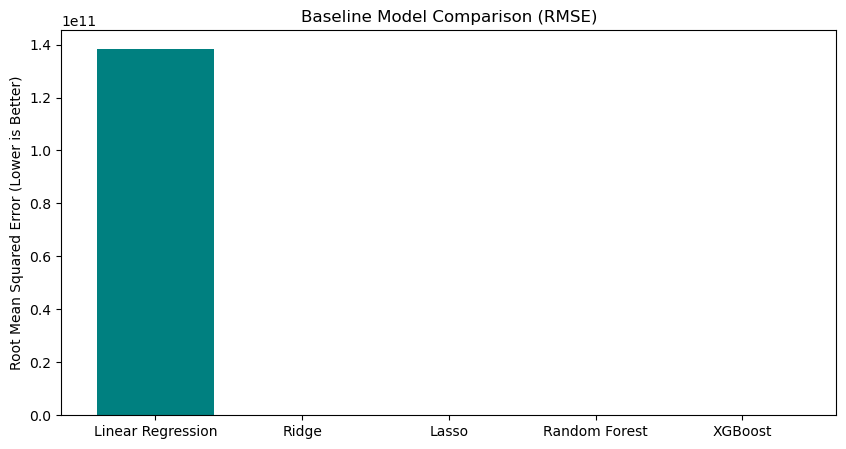

In [58]:
# comparing model performance
models = ['Linear Regression', 'Ridge', 'Lasso', 'Random Forest', 'XGBoost']
rmses = [
    np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    np.sqrt(mean_squared_error(y_test, y_pred_lasso)),
    np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    np.sqrt(mean_squared_error(y_test, y_pred_xgb))
]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(models, rmses, color='teal')
plt.ylabel('Root Mean Squared Error (Lower is Better)')
plt.title('Baseline Model Comparison (RMSE)')
plt.show()


### step 7 hyperparameter tuning

In [62]:
# RandomForest regressor tuning
from sklearn.model_selection import GridSearchCV

param_grids = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grids, cv=3, scoring='neg_mean_squared_error', verbose=True, n_jobs=1)

grid_search_rf.fit(x_train, y_train)
best_rf = grid_search_rf.best_estimator_

print("Best Random Forest Params:", grid_search_rf.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [64]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred_best_rf = best_rf.predict(x_test)
print("Tuned Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best_rf)))

Tuned Random Forest RMSE: 0.011315241734157929


In [68]:
# XGboost tuning
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1]
}

xgb = XGBRegressor(random_state=42)
random_search_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, cv=3, n_iter=10, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, random_state=42)

random_search_xgb.fit(x_train, y_train)
best_xgb = random_search_xgb.best_estimator_

print(f'XGBoost params best: {random_search_xgb.best_params_}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
XGBoost params best: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [71]:
y_pred_best_xgb = best_xgb.predict(x_test)
print(f'tuned xgboost RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb))}')

tuned xgboost RMSE: 0.011200419175786964


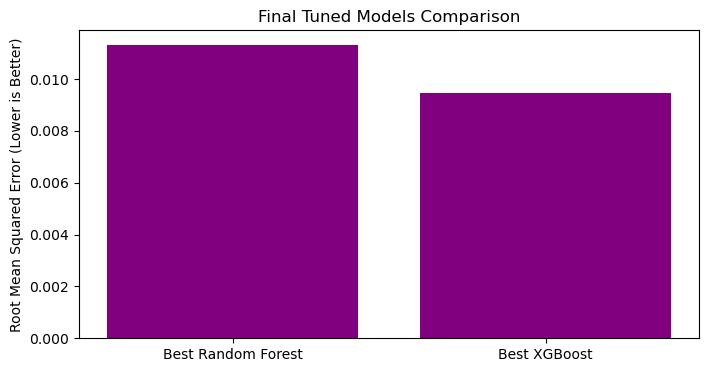

In [72]:
models = ['Best Random Forest', 'Best XGBoost']
rmses = [
    np.sqrt(mean_squared_error(y_test, y_pred_best_rf)),
    np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))
]

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.bar(models, rmses, color='purple')
plt.ylabel('Root Mean Squared Error (Lower is Better)')
plt.title('Final Tuned Models Comparison')
plt.show()

### step 8 final model interpretation

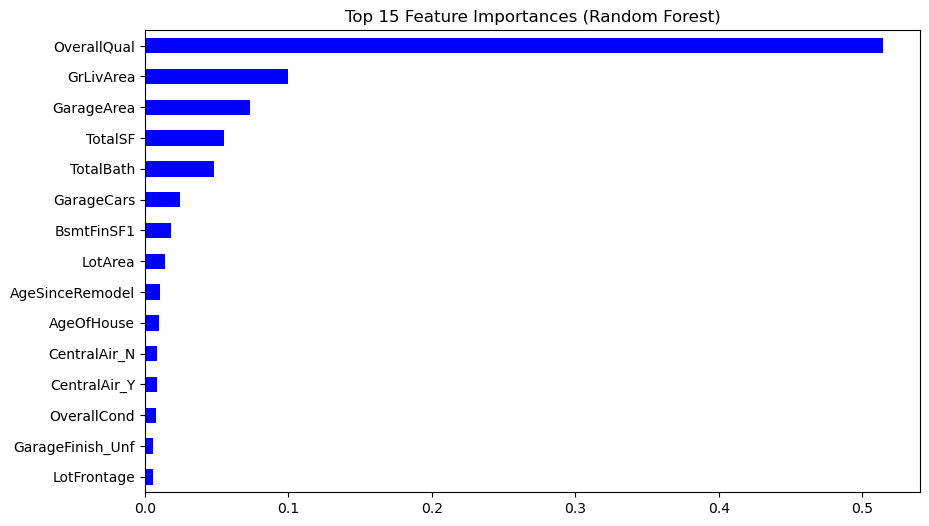

In [74]:
# feature importance
importance_rf = pd.Series(best_rf.feature_importances_, index=x.columns)
importance_rf.nlargest(15).sort_values().plot(kind='barh', figsize=(10,6), color='blue')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.show()

ValueError: Unknown format code 'f' for object of type 'str'

<Figure size 1400x1000 with 0 Axes>

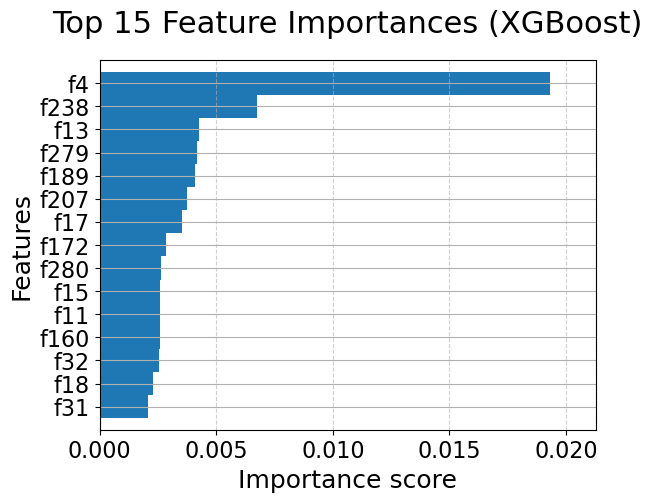

In [83]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Create a larger figure with appropriate dimensions
plt.figure(figsize=(14, 10))

# Increase font sizes significantly
plt.rcParams['font.size'] = 16          # Larger base font size
plt.rcParams['axes.titlesize'] = 20     # Larger title font size
plt.rcParams['axes.labelsize'] = 18     # Larger axis label font size
plt.rcParams['xtick.labelsize'] = 16    # Larger x-tick labels
plt.rcParams['ytick.labelsize'] = 16    # Larger y-tick labels

# Plot with custom parameters for better visibility
ax = plot_importance(best_xgb, 
                    max_num_features=15, 
                    height=1.0,         # Even taller bars
                    importance_type='gain',
                    show_values=False)  # Hide values to reduce clutter

# Customize the plot further
plt.title('Top 15 Feature Importances (XGBoost)', fontsize=22, pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.6)  # Add grid lines for readability

# Add values at the end of each bar
for i, (val, key) in enumerate(zip(ax.get_xlabel(), ax.get_ylabel())):
    ax.text(val, i, f' {val:.4f}', va='center', fontsize=14)

plt.tight_layout()  # Ensure everything fits
plt.show()

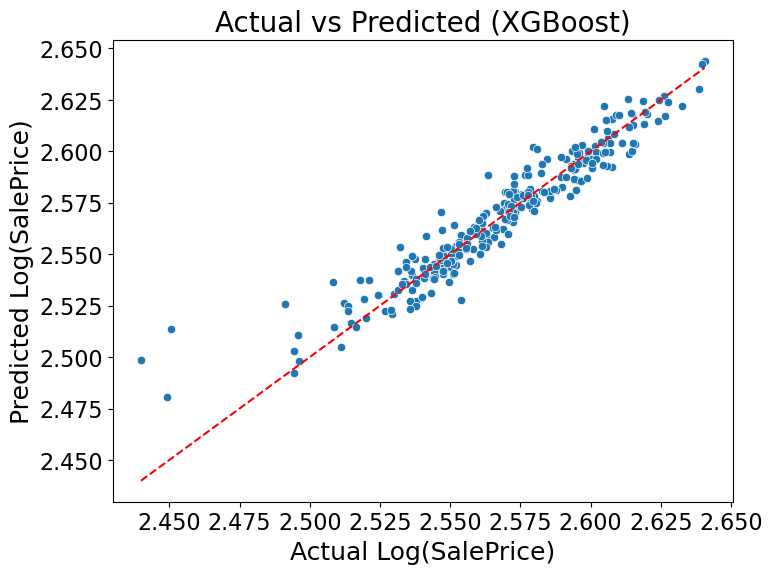

In [84]:
# error analysis to know that where model struggles
import seaborn as sns 

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_best_xgb)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Log(SalePrice)')
plt.ylabel('Predicted Log(SalePrice)')
plt.title('Actual vs Predicted (XGBoost)')
plt.show()

In [85]:
# examine the worst predictions
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best_xgb})
comparison['Error'] = abs(comparison['Actual'] - comparison['Predicted'])
comparison.sort_values(by='Error', ascending=False).head(10)

,Actual,Predicted,Error
30,2.450717,2.513759,0.063042
916,2.439907,2.498471,0.058564
1432,2.491090,2.525747,0.034656
533,2.449194,2.480486,0.031292
589,2.508259,2.536626,0.028367
277,2.553851,2.527601,0.026251
716,2.563395,2.588376,0.024982
666,2.546909,2.570686,0.023778
1031,2.579532,2.602108,0.022576
772,2.532155,2.553395,0.021240


### step 9 final model

In [86]:
# saving model with joblib
import joblib

joblib.dump(best_xgb, 'best_xgb_model.pkl')

# saving the scaler since we scaled it too 
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
# for loading and using it 

# Load model
# loaded_model = joblib.load('best_xgb_model.pkl')
# loaded_scaler = joblib.load('scaler.pkl')

# Example: Predict on new data
# Suppose new_data is your new house features as a dataframe
# X_scaled_new = loaded_scaler.transform(new_data)

# prediction = loaded_model.predict(X_scaled_new)
# print(prediction)
